# Track Reconstruction from Data Events

This notebook reconstructs track parameters from simulated data events by combining:
- Event loading from `generate_muon_data_events.ipynb`
- Optimization techniques from `track_optimization.ipynb`

The goal is to find the best track parameters (energy, position, direction) that reproduce the observed charge and timing patterns.

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
import sys
sys.path.append('..')

import jax
import jax.numpy as jnp
import numpy as np
import h5py
import matplotlib.pyplot as plt
from pathlib import Path

# Import necessary modules
from tools.simulation import setup_event_simulator
from tools.geometry import generate_detector
from tools.visualization import create_detector_display, create_detector_comparison_display
from tools.utils import read_event_file, extract_particle_properties, analyze_loaded_particle
from tools.optimization import create_multi_objective_optimizer

## Setup Detector and Simulator

In [3]:
# Configuration
json_filename = '../config/IWCD_geom_config.json'
Nphot = 1_000_000  # Reduced for faster reconstruction

# Generate detector geometry
detector = generate_detector(json_filename)
detector_points = jnp.array(detector.all_points)
NUM_DETECTORS = len(detector_points)

print(f"Detector has {NUM_DETECTORS} PMTs")

# Setup event simulator for reconstruction
simulate_event = setup_event_simulator(json_filename, Nphot, K=5, is_data=False, temperature=0.)

# Detector parameters for simulation
detector_params = (
    jnp.array(100),          # scatter_length
    jnp.array(0.05),         # reflection_rate
    jnp.array(100000.),      # absorption_length
    jnp.array(0.001)         # gumbel_softmax_temp
)

Detector has 9720 PMTs


## Load Data Event

In [21]:
# Load the data event to reconstruct
data_filename = 'output/event_0.h5'

# Check if file exists, if not create some test data
if not Path(data_filename).exists():
    print(f"Data file {data_filename} not found.")
    print("Please run generate_muon_data_events.ipynb first to create test data.")
    # You could also generate a test event here if needed
else:
    print(f"Loading data from {data_filename}")
    
    # Read the event file to see its structure
    data_dict = read_event_file(data_filename, verbose=True)

Loading data from output/event_1.h5

File: event_1.h5
Event Number: 1
Number of tracks: 1
Number of detectors: 9720

Particle Information:
--------------------------------------------------------------------------------
Track # PDG     Q_tot       P_mag (MeV/c)   Direction                Vertex                   
--------------------------------------------------------------------------------
0       Muon    199671.78   813.70          [ 0.5310586  -0.76835513 -0.35722136][ 0.07003345  0.01272795 -0.00773768]

Detector Statistics:
Total charge detected: 199671.78
Mean charge per track: 199671.78
Mean charge per PMT: 20.54
Number of PMTs with signal: 8326

Charge Matrix (Q) - First 10 PMTs:
--------------------------------------------------------------------------------
Track #  PMT-0     PMT-1     PMT-2     PMT-3     PMT-4     PMT-5     PMT-6     PMT-7     PMT-8     PMT-9     
--------------------------------------------------------------------------------
0         3.00    5.00    7.0

In [22]:
# Extract data from the loaded event
with h5py.File(data_filename, 'r') as f:
    data_charges = np.array(f['Q'])[0]  # Shape: (N_detectors,)
    data_times = np.array(f['T'])[0]    # Shape: (N_detectors,)
    true_mom = np.array(f['P'])[0]      # True momentum for comparison
    true_vtx = np.array(f['V'])[0]      # True vertex for comparison
    pdg_code = np.array(f['PDG'])[0]    # Particle type

# Extract true parameters for comparison
true_particle_info = analyze_loaded_particle(true_mom, true_vtx, pdg_code)

print("\nTrue Track Parameters:")
print(f"Energy: {true_particle_info['kinetic_energy']:.2f} MeV")
print(f"Theta: {true_particle_info['theta_deg']:.2f}°")
print(f"Phi: {true_particle_info['phi_deg']:.2f}°")
print(f"Vertex: [{true_vtx[0]:.3f}, {true_vtx[1]:.3f}, {true_vtx[2]:.3f}] m")
print(f"Total charge: {np.sum(data_charges):.2f}")
print(f"PMTs with signal: {np.sum(data_charges > 0)}")


True Track Parameters:
Energy: 714.84 MeV
Theta: 110.93°
Phi: -55.35°
Vertex: [0.070, 0.013, -0.008] m
Total charge: 199671.78
PMTs with signal: 8326


## Visualize Data Event

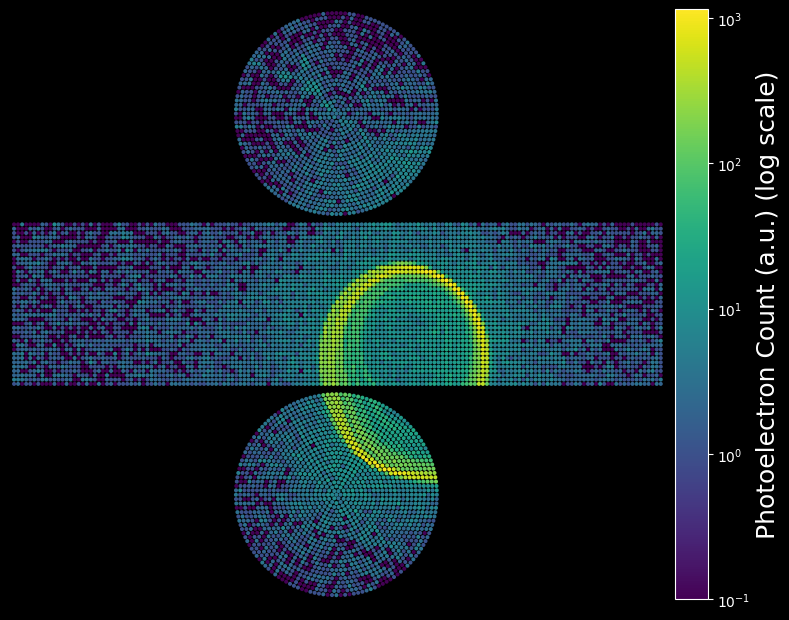

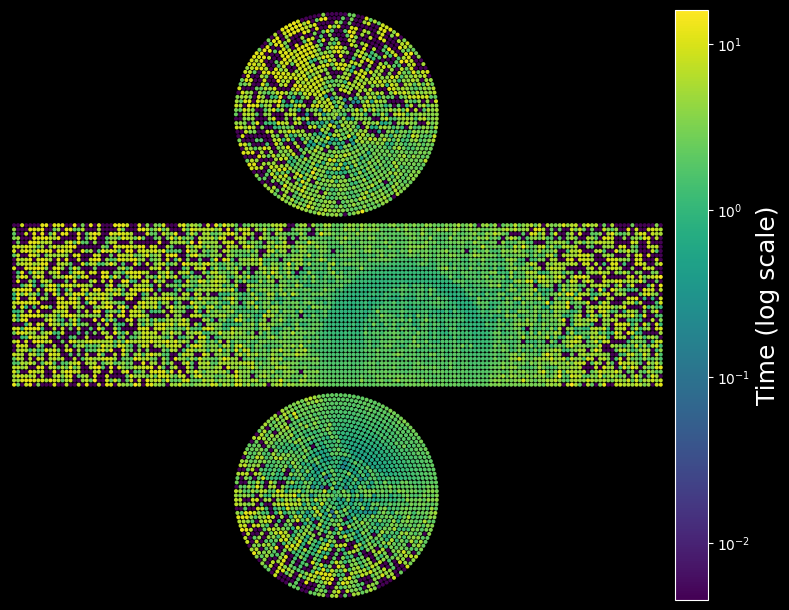

In [23]:
# Create visualization
detector_display = create_detector_display(json_filename, sparse=False)

# Display charge pattern
detector_display(data_charges, data_times, 
                file_name='figures/data_event_charge.pdf', 
                plot_time=False, log_scale=True)

# Display time pattern
detector_display(data_charges, data_times, 
                file_name='figures/data_event_time.pdf', 
                plot_time=True, log_scale=True)

## Set up Optimization for Track Reconstruction

In [7]:
# Define loss function for track reconstruction
def reconstruction_loss(predicted_charges, predicted_times, data_charges, data_times, 
                       lambda_time=0.1, epsilon=1e-3):
    """
    Loss function comparing predicted and observed charges/times.
    
    Args:
        predicted_charges: Simulated charge pattern
        predicted_times: Simulated time pattern  
        data_charges: Observed charge pattern
        data_times: Observed time pattern
        lambda_time: Weight for time component
        epsilon: Small value to avoid division by zero (increased from 1e-6)
    """
    # Add small epsilon to avoid numerical issues
    data_charges_safe = data_charges + epsilon
    predicted_charges_safe = predicted_charges + epsilon
    
    # Charge loss using relative difference
    charge_diff = (predicted_charges - data_charges) / data_charges_safe
    charge_loss = jnp.mean(charge_diff**2)
    
    # Alternative: Log-based loss for better stability
    # charge_loss = jnp.mean((jnp.log(predicted_charges_safe) - jnp.log(data_charges_safe))**2)
    
    # Time loss (only for PMTs with significant signal in both)
    signal_threshold = 0.5  # Increased threshold
    signal_mask = (data_charges > signal_threshold) & (predicted_charges > signal_threshold)
    
    if jnp.sum(signal_mask) > 10:  # Need at least 10 PMTs
        time_diff = (predicted_times - data_times)[signal_mask]
        time_loss = jnp.mean(time_diff**2) / 100.0  # Scale down time loss
    else:
        time_loss = 0.0
    
    total_loss = charge_loss + lambda_time * time_loss
    
    # Add penalty if total charge is very different
    total_charge_ratio = jnp.sum(predicted_charges) / (jnp.sum(data_charges) + epsilon)
    charge_penalty = jnp.abs(jnp.log(total_charge_ratio + epsilon))
    
    return total_loss + 0.1 * charge_penalty

# Create objective function for optimization
def create_reconstruction_objective(data_charges, data_times, simulate_event, 
                                  detector_params, lambda_time=0.1):
    """
    Create objective function for track reconstruction.
    """
    # Pre-compute some statistics about the data
    data_total_charge = jnp.sum(data_charges)
    print(f"Data total charge: {data_total_charge:.2f}")
    print(f"Data PMTs with signal > 0.5: {jnp.sum(data_charges > 0.5)}")
    
    def objective(params, key):
        energy, vertex, angles = params
        
        # Check parameters are valid
        if energy <= 0 or energy > 10000:
            return jnp.array(1e10)  # Large penalty for invalid energy
        
        # Create track parameters
        track_params = (energy, vertex, angles)
        
        try:
            # Simulate event
            predicted_charges, predicted_times = simulate_event(track_params, detector_params, key)
            
            # Check for valid output
            if jnp.any(jnp.isnan(predicted_charges)) or jnp.any(jnp.isnan(predicted_times)):
                print(f"NaN in simulation output! Params: E={energy}, V={vertex}, angles={angles}")
                return jnp.array(1e10)
            
            # Calculate loss
            loss = reconstruction_loss(predicted_charges, predicted_times, 
                                     data_charges, data_times, lambda_time)
            
            return loss
            
        except Exception as e:
            print(f"Error in objective function: {e}")
            print(f"Params: E={energy}, V={vertex}, angles={angles}")
            return jnp.array(1e10)
    
    return objective

## Run Track Reconstruction

In [8]:
# Create objective function
objective_fn = create_reconstruction_objective(
    data_charges, data_times, simulate_event, detector_params, lambda_time=0.1
)

# Initial guess parameters (you can start with random or educated guesses)
initial_energy = 500.0  # MeV
initial_vertex = jnp.array([0.0, 0.0, 0.0])  # meters
initial_angles = jnp.array([jnp.pi/4, 0.0])  # theta, phi in radians

initial_params = (initial_energy, initial_vertex, initial_angles)

print("Initial guess:")
print(f"Energy: {initial_energy:.2f} MeV")
print(f"Vertex: [{initial_vertex[0]:.3f}, {initial_vertex[1]:.3f}, {initial_vertex[2]:.3f}] m")
print(f"Theta: {np.degrees(initial_angles[0]):.2f}°")
print(f"Phi: {np.degrees(initial_angles[1]):.2f}°")

Data total charge: 251118.12
Data PMTs with signal > 0.5: 8711
Initial guess:
Energy: 500.00 MeV
Vertex: [0.000, 0.000, 0.000] m
Theta: 45.00°
Phi: 0.00°


In [16]:
# Set up optimization using JAX
import optax

# More conservative learning rates
energy_lr = 1.0      # Reduced from 5.0
spatial_lr = 0.01    # Reduced from 0.05
angular_lr = 0.005   # Reduced from 0.01

# Create optimizers for each parameter type with gradient clipping
energy_optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip gradients
    optax.adam(energy_lr)
)
spatial_optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(spatial_lr)
)
angular_optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(angular_lr)
)

# Initialize optimizer states
energy_opt_state = energy_optimizer.init(initial_energy)
spatial_opt_state = spatial_optimizer.init(initial_vertex)
angular_opt_state = angular_optimizer.init(initial_angles)

# Current parameters (use JAX arrays)
current_energy = jnp.array(initial_energy)
current_vertex = jnp.array(initial_vertex)
current_angles = jnp.array(initial_angles)

# Storage for optimization history
loss_history = []
energy_history = []
vertex_history = []
angle_history = []

# Optimization parameters
n_iterations = 200
patience = 50
min_improvement = 1e-6

print(f"Starting optimization with {n_iterations} iterations...")
print(f"Learning rates: energy={energy_lr}, spatial={spatial_lr}, angular={angular_lr}")

Starting optimization with 200 iterations...
Learning rates: energy=1.0, spatial=0.01, angular=0.005


In [17]:
# Run optimization loop with debug prints
best_loss = float('inf')
patience_counter = 0
key = jax.random.PRNGKey(42)

# Add debug flag
debug = True

for iteration in range(n_iterations):
    # Generate new random key for each iteration
    key, subkey = jax.random.split(key)
    
    # Current parameters
    current_params = (current_energy, current_vertex, current_angles)
    
    if debug and iteration < 5:  # Debug first few iterations
        print(f"\n--- Iteration {iteration} ---")
        print(f"Current params before grad:")
        print(f"  Energy: {current_energy}")
        print(f"  Vertex: {current_vertex}")
        print(f"  Angles: {current_angles} (theta={np.degrees(current_angles[0]):.1f}°, phi={np.degrees(current_angles[1]):.1f}°)")
        
    # Compute loss and gradients
    loss, grads = jax.value_and_grad(objective_fn)(current_params, subkey)
    
    # Check for NaN in loss
    if jnp.isnan(loss):
        print(f"\n!!! NaN detected in loss at iteration {iteration} !!!")
        print(f"Current params: E={current_energy}, V={current_vertex}, angles={current_angles}")
        
        # Try to simulate event to see what's happening
        test_charges, test_times = simulate_event(current_params, detector_params, subkey)
        print(f"Simulated charges - sum: {jnp.sum(test_charges)}, max: {jnp.max(test_charges)}, has_nan: {jnp.any(jnp.isnan(test_charges))}")
        print(f"Simulated times - max: {jnp.max(test_times)}, has_nan: {jnp.any(jnp.isnan(test_times))}")
        break
    
    # Unpack gradients
    energy_grad, vertex_grad, angles_grad = grads
    
    if debug and iteration < 5:
        print(f"Gradients:")
        print(f"  Energy grad: {energy_grad}, is_nan: {jnp.isnan(energy_grad)}")
        print(f"  Vertex grad: {vertex_grad}, has_nan: {jnp.any(jnp.isnan(vertex_grad))}")
        print(f"  Angles grad: {angles_grad}, has_nan: {jnp.any(jnp.isnan(angles_grad))}")
        print(f"  Loss: {loss}")
    
    # Check for NaN in gradients
    if jnp.any(jnp.isnan(energy_grad)) or jnp.any(jnp.isnan(vertex_grad)) or jnp.any(jnp.isnan(angles_grad)):
        print(f"\n!!! NaN detected in gradients at iteration {iteration} !!!")
        print(f"Energy grad: {energy_grad}")
        print(f"Vertex grad: {vertex_grad}")
        print(f"Angles grad: {angles_grad}")
        break
    
    # Update parameters using their respective optimizers
    energy_updates, energy_opt_state = energy_optimizer.update(energy_grad, energy_opt_state)
    current_energy = optax.apply_updates(current_energy, energy_updates)
    
    vertex_updates, spatial_opt_state = spatial_optimizer.update(vertex_grad, spatial_opt_state)
    current_vertex = optax.apply_updates(current_vertex, vertex_updates)
    
    angles_updates, angular_opt_state = angular_optimizer.update(angles_grad, angular_opt_state)
    current_angles = optax.apply_updates(current_angles, angles_updates)
    
    if debug and iteration < 5:
        print(f"Updates:")
        print(f"  Energy update: {energy_updates}")
        print(f"  Vertex update: {vertex_updates}")
        print(f"  Angles update: {angles_updates}")
    
    # Check parameters before clipping
    if debug and iteration < 5:
        print(f"Before clipping:")
        print(f"  Energy: {current_energy}, is_nan: {jnp.isnan(current_energy)}")
        print(f"  Vertex: {current_vertex}, has_nan: {jnp.any(jnp.isnan(current_vertex))}")
        print(f"  Angles: {current_angles}, has_nan: {jnp.any(jnp.isnan(current_angles))}")
    
    # Constrain parameters to physical ranges
    current_energy = 878.#jnp.clip(current_energy, 10.0, 5000.0)  # 10 MeV to 5 GeV
    #current_vertex = jnp.array([0.068, -0.064, -0.055])#jnp.clip(current_vertex, -2.0, 2.0)     # ±2m detector range
    #current_angles = jnp.array([0.8793572 , 0.11799106])#current_angles.at[0].set(jnp.clip(current_angles[0], 0.01, jnp.pi-0.01))  # theta
    #print(current_angles)
    #current_angles = jnp.array((true_particle_info['theta_rad'], true_particle_info['phi_rad'])) #current_angles.at[1].set(current_angles[1] % (2*jnp.pi))  # phi wrapping
    
    # Check for NaN after updates
    if jnp.isnan(current_energy) or jnp.any(jnp.isnan(current_vertex)) or jnp.any(jnp.isnan(current_angles)):
        print(f"\n!!! NaN detected in parameters after update at iteration {iteration} !!!")
        print(f"Energy: {current_energy}")
        print(f"Vertex: {current_vertex}")
        print(f"Angles: {current_angles}")
        break
    
    # Store history
    loss_history.append(float(loss))
    energy_history.append(float(current_energy))
    vertex_history.append(np.array(current_vertex))
    angle_history.append(np.array(current_angles))
    
    # Check for improvement
    if loss < best_loss - min_improvement:
        best_loss = loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print progress
    if iteration % 20 == 0 or iteration < 10:
        print(f"\nIter {iteration:3d}: Loss={loss:.6f}, E={current_energy:.1f} MeV, "
              f"θ={np.degrees(current_angles[0]):.1f}°, φ={np.degrees(current_angles[1]):.1f}°")
        
        # Additional debug info for problematic iterations
        if jnp.isnan(loss) or loss > 1e10:
            print(f"  WARNING: Loss is {loss}")
            print(f"  Total sim charge: {jnp.sum(simulate_event(current_params, detector_params, subkey)[0])}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at iteration {iteration} (no improvement for {patience} iterations)")
        break

print(f"\nOptimization completed after {len(loss_history)} iterations")
print(f"Final loss: {loss_history[-1]:.6f}")

# Check if optimization failed
if len(loss_history) == 0 or jnp.isnan(loss_history[-1]):
    print("\n!!! Optimization failed - check debug output above !!!")

jnp.array((true_particle_info['theta_rad'], true_particle_info['phi_rad']))


--- Iteration 0 ---
Current params before grad:
  Energy: 500.0
  Vertex: [0. 0. 0.]
  Angles: [0.7853982 0.       ] (theta=45.0°, phi=0.0°)
Gradients:
  Energy grad: 392.6259460449219, is_nan: False
  Vertex grad: [-4871.538     -40.18654 -4254.8506 ], has_nan: False
  Angles grad: [-1077.9077    121.55004], has_nan: False
  Loss: 39968.89453125
Updates:
  Energy update: -0.9999932646751404
  Vertex update: [0.00999993 0.00999992 0.00999993]
  Angles update: [ 0.00499997 -0.00499997]
Before clipping:
  Energy: 499.0, is_nan: False
  Vertex: [0.00999993 0.00999992 0.00999993], has_nan: False
  Angles: [ 0.7903981  -0.00499997], has_nan: False

Iter   0: Loss=39968.894531, E=878.0 MeV, θ=45.3°, φ=-0.3°

--- Iteration 1 ---
Current params before grad:
  Energy: 878.0
  Vertex: [0.00999993 0.00999992 0.00999993]
  Angles: [ 0.7903981  -0.00499997] (theta=45.3°, phi=-0.3°)
Gradients:
  Energy grad: 411.3642883300781, is_nan: False
  Vertex grad: [-17122.52      -193.12346 -14420.82   ], h

Array([0.8793572 , 0.11799106], dtype=float32)

## Compare Reconstructed vs True Parameters

In [18]:
# Final reconstructed parameters
reconstructed_energy = float(current_energy)
reconstructed_vertex = np.array(current_vertex)
reconstructed_angles = np.array(current_angles)
reconstructed_theta_deg = np.degrees(reconstructed_angles[0])
reconstructed_phi_deg = np.degrees(reconstructed_angles[1])

print("\n" + "="*60)
print("TRACK RECONSTRUCTION RESULTS")
print("="*60)

print("\nTrue Parameters:")
print(f"  Energy:     {true_particle_info['kinetic_energy']:.2f} MeV")
print(f"  Theta:      {true_particle_info['theta_deg']:.2f}°")
print(f"  Phi:        {true_particle_info['phi_deg']:.2f}°")
print(f"  Vertex:     [{true_vtx[0]:.3f}, {true_vtx[1]:.3f}, {true_vtx[2]:.3f}] m")

print("\nReconstructed Parameters:")
print(f"  Energy:     {reconstructed_energy:.2f} MeV")
print(f"  Theta:      {reconstructed_theta_deg:.2f}°")
print(f"  Phi:        {reconstructed_phi_deg:.2f}°")
print(f"  Vertex:     [{reconstructed_vertex[0]:.3f}, {reconstructed_vertex[1]:.3f}, {reconstructed_vertex[2]:.3f}] m")

print("\nReconstruction Errors:")
energy_error = abs(reconstructed_energy - true_particle_info['kinetic_energy'])
theta_error = abs(reconstructed_theta_deg - true_particle_info['theta_deg'])
phi_error = abs(reconstructed_phi_deg - true_particle_info['phi_deg'])
vertex_error = np.linalg.norm(reconstructed_vertex - true_vtx)

print(f"  Energy:     {energy_error:.2f} MeV ({energy_error/true_particle_info['kinetic_energy']*100:.1f}%)")
print(f"  Theta:      {theta_error:.2f}°")
print(f"  Phi:        {phi_error:.2f}°")
print(f"  Vertex:     {vertex_error:.3f} m")


TRACK RECONSTRUCTION RESULTS

True Parameters:
  Energy:     878.25 MeV
  Theta:      50.38°
  Phi:        6.76°
  Vertex:     [0.068, -0.064, -0.055] m

Reconstructed Parameters:
  Energy:     878.00 MeV
  Theta:      59.00°
  Phi:        6.81°
  Vertex:     [0.519, 0.575, 0.464] m

Reconstruction Errors:
  Energy:     0.25 MeV (0.0%)
  Theta:      8.62°
  Phi:        0.04°
  Vertex:     0.938 m


## Generate Reconstructed Event and Compare

In [19]:
# Generate event using reconstructed parameters
final_track_params = (reconstructed_energy, reconstructed_vertex, reconstructed_angles)
key = jax.random.PRNGKey(42)
reconstructed_charges, reconstructed_times = simulate_event(final_track_params, detector_params, key)

print(f"Data event - Total charge: {np.sum(data_charges):.2f}, PMTs hit: {np.sum(data_charges > 0)}")
print(f"Reconstructed - Total charge: {np.sum(reconstructed_charges):.2f}, PMTs hit: {np.sum(reconstructed_charges > 0)}")

# Calculate reconstruction quality metrics
charge_correlation = np.corrcoef(data_charges, reconstructed_charges)[0, 1]
charge_rmse = np.sqrt(np.mean((data_charges - reconstructed_charges)**2))

print(f"\nCharge pattern correlation: {charge_correlation:.4f}")
print(f"Charge RMSE: {charge_rmse:.4f}")

Data event - Total charge: 251118.11, PMTs hit: 8711
Reconstructed - Total charge: 259965.88, PMTs hit: 9720

Charge pattern correlation: 0.1579
Charge RMSE: 128.9386


## Visualize Comparison

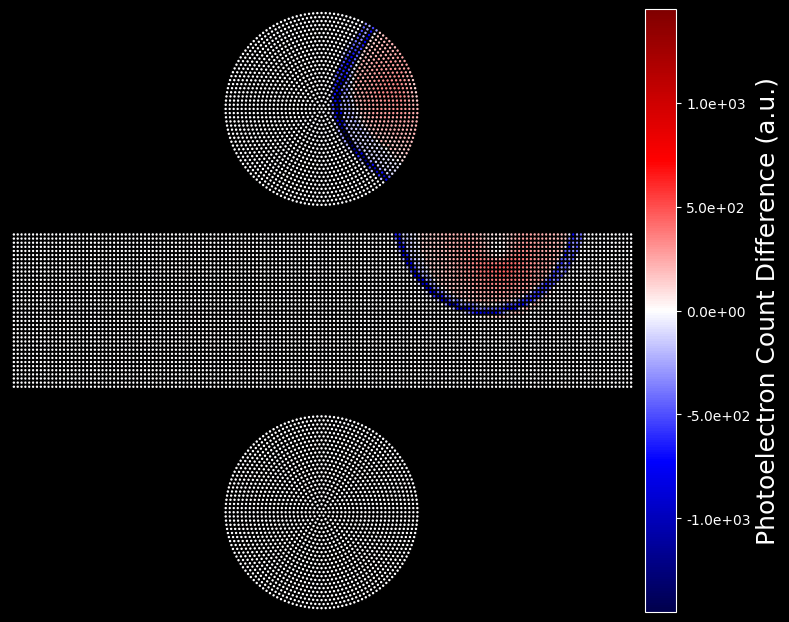

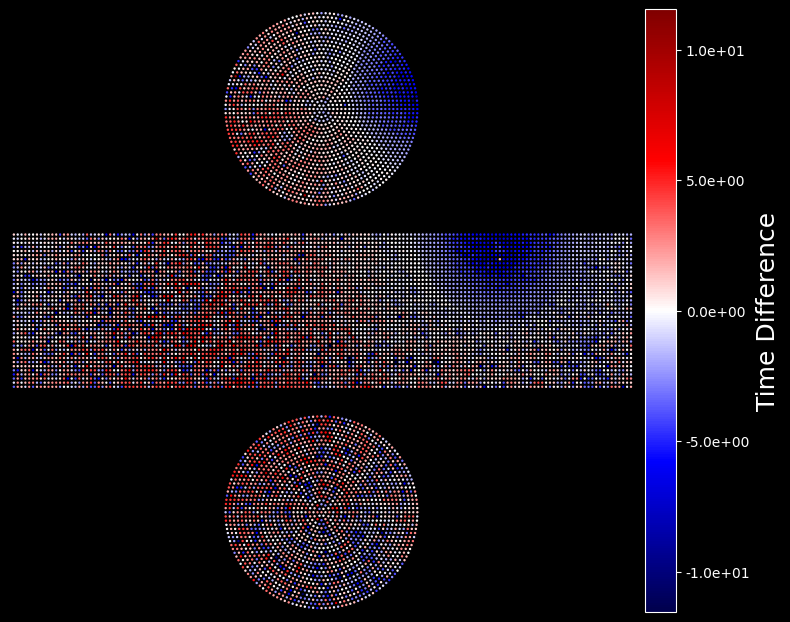

In [20]:
# Create comparison display
detector_comparison = create_detector_comparison_display(json_filename, sparse=False)

# Compare charge patterns
detector_comparison(
    (data_charges, data_times),  # true_data as tuple
    (reconstructed_charges, reconstructed_times),  # sim_data as tuple
    file_name='figures/reconstruction_charge_comparison.pdf',
    plot_time=False
)

# Compare time patterns  
detector_comparison(
    (data_charges, data_times),  # true_data as tuple
    (reconstructed_charges, reconstructed_times),  # sim_data as tuple
    file_name='figures/reconstruction_time_comparison.pdf',
    plot_time=True,
    align_time=True  # This will align the mean times
)

## Plot Optimization History

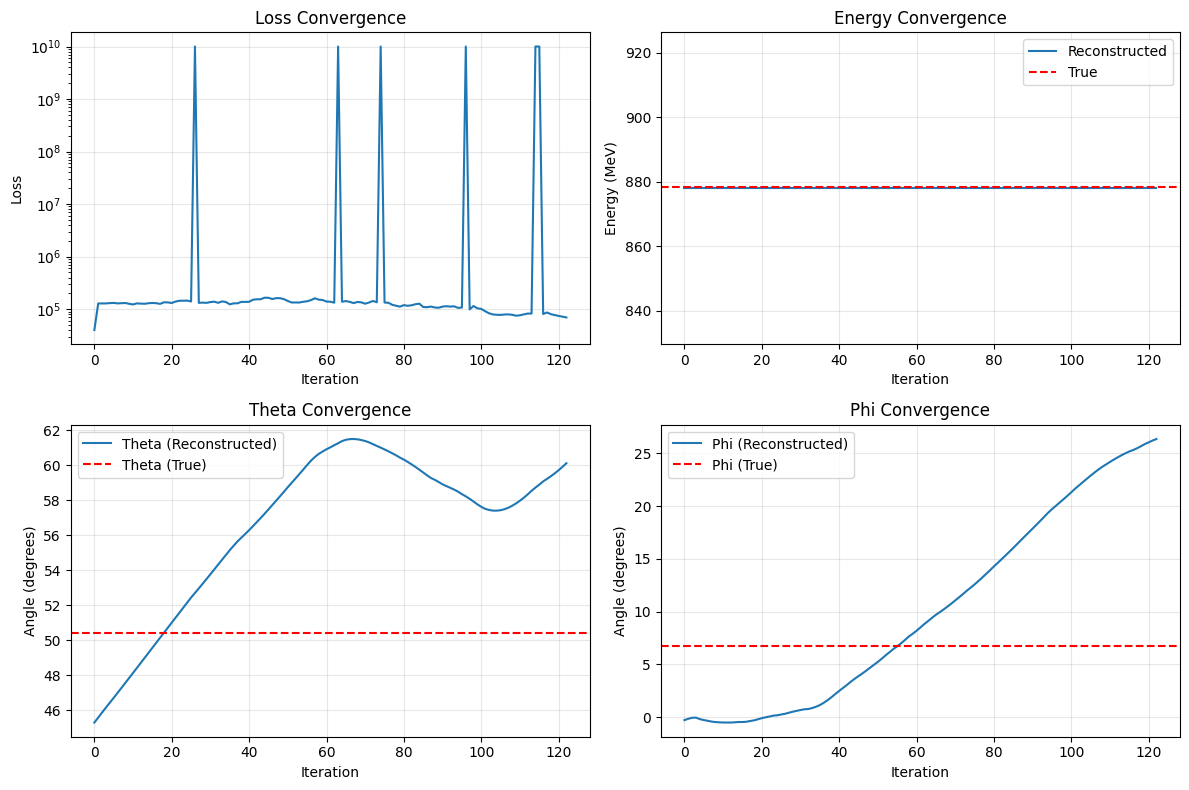

In [14]:
# Plot convergence history
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loss history
axes[0, 0].plot(loss_history)
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss Convergence')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# Energy history
axes[0, 1].plot(energy_history, label='Reconstructed')
axes[0, 1].axhline(true_particle_info['kinetic_energy'], color='red', linestyle='--', label='True')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Energy (MeV)')
axes[0, 1].set_title('Energy Convergence')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Angle history
theta_history = [np.degrees(angles[0]) for angles in angle_history]
phi_history = [np.degrees(angles[1]) for angles in angle_history]

axes[1, 0].plot(theta_history, label='Theta (Reconstructed)')
axes[1, 0].axhline(true_particle_info['theta_deg'], color='red', linestyle='--', label='Theta (True)')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Angle (degrees)')
axes[1, 0].set_title('Theta Convergence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(phi_history, label='Phi (Reconstructed)')
axes[1, 1].axhline(true_particle_info['phi_deg'], color='red', linestyle='--', label='Phi (True)')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Angle (degrees)')
axes[1, 1].set_title('Phi Convergence')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/reconstruction_convergence.pdf', dpi=300, bbox_inches='tight')
plt.show()

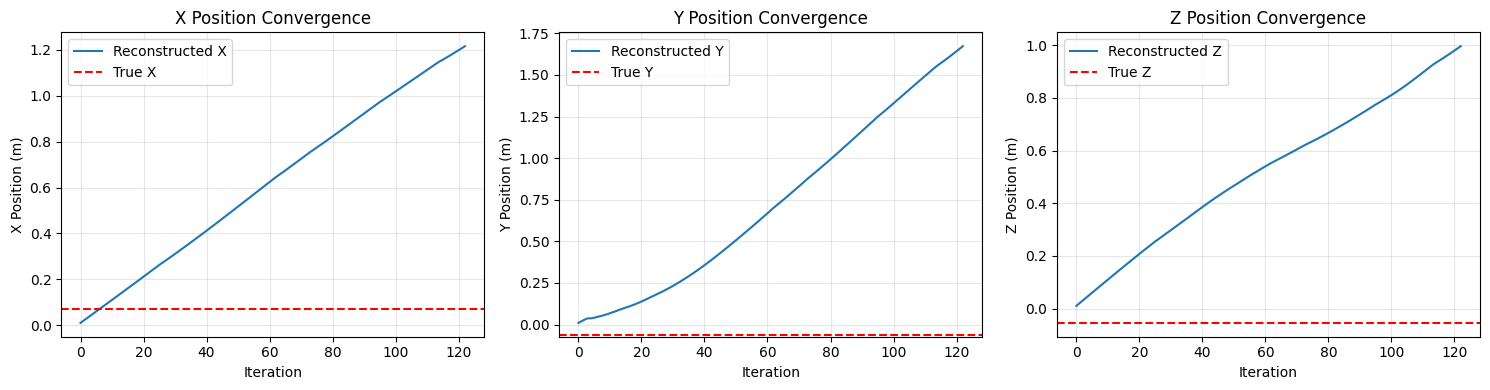

In [15]:
# Plot vertex position convergence
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

vertex_x = [v[0] for v in vertex_history]
vertex_y = [v[1] for v in vertex_history]
vertex_z = [v[2] for v in vertex_history]

axes[0].plot(vertex_x, label='Reconstructed X')
axes[0].axhline(true_vtx[0], color='red', linestyle='--', label='True X')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('X Position (m)')
axes[0].set_title('X Position Convergence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(vertex_y, label='Reconstructed Y')
axes[1].axhline(true_vtx[1], color='red', linestyle='--', label='True Y')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Y Position (m)')
axes[1].set_title('Y Position Convergence')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(vertex_z, label='Reconstructed Z')
axes[2].axhline(true_vtx[2], color='red', linestyle='--', label='True Z')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Z Position (m)')
axes[2].set_title('Z Position Convergence')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/vertex_reconstruction_convergence.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Summary

This notebook demonstrates track reconstruction from simulated data events by:

1. **Loading a data event** with known charge and timing patterns
2. **Setting up optimization** with appropriate loss functions and learning rates
3. **Reconstructing track parameters** (energy, position, direction) through iterative optimization
4. **Comparing results** against the true parameters
5. **Visualizing** both the optimization convergence and the quality of the reconstruction

The reconstruction quality depends on:
- Initial parameter guesses
- Learning rates and optimization strategy
- Loss function design (charge vs time weighting)
- Number of photons used in simulation
- Detector geometry and resolution